In [2]:
import numpy as np
from libitmal import dataloaders_v3 as dataloaders

X, y = dataloaders.MNIST_GetDataSet(fetchmode=False)

X = X.reshape(70000, 784)
#X_norm = X*np.float32(1)   # NOTE: ups, remembered convert to float but forgot scale 
X_norm = X/np.float32(255) # NOTE: remembered convert to float and scale 

print(f"X_norm.shape={X_norm.shape}")
print(f"  type(X_norm[0][0])={type(X_norm[0][0])}")
print(f"  X_norm.dtype={X_norm.dtype}")
print(f"  np.max(X_norm)={np.max(X_norm)}")
print(f"  np.min(X_norm)={np.min(X_norm)}")

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

X_norm.shape=(70000, 784)
  type(X_norm[0][0])=<class 'numpy.float32'>
  X_norm.dtype=float32
  np.max(X_norm)=1.0
  np.min(X_norm)=0.0


In [6]:
from time import time

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
#from keras.backend import batch_normalization

def AddLayer(model, units, add_normalization=False, dropout_rate=-1):
    model.add(Dense(units=units, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
    if add_normalization:
        model.add(BatchNormalization())
    if dropout_rate>=0:
        model.add(Dropout(rate=dropout_rate))


model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(input_dim=(784), units=20, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
#model.add(BatchNormalization())
#model.add(Dropout(rate=DROPOUT_RATE))

# Grp10: 20, 50, 70, 100, 70, 50, 20
AddLayer(model, 50)
AddLayer(model, 70)
AddLayer(model, 100)
AddLayer(model, 70)
AddLayer(model, 50)
AddLayer(model, 20)

model.add(Dense(units=10, 
                activation="softmax",
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     

def ModelCompile(model):
    #optimizer = Adam (lr=0.1) # NOTE: will fail miserable for lr=0.1
    #optimizer = Adam (lr=0.01) 
    #optimizer = Nadam(lr=0.002) # NOTE: Nadam=Nesterov Adam optimizer.
    optimizer = SGD  (lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
          
    model.compile(loss='categorical_crossentropy', 
            optimizer=optimizer, 
             metrics=['categorical_crossentropy',
                       'categorical_accuracy',
                       'mean_squared_error',
                       'mean_absolute_error'])
    try:
        model.summary()
    except:
        print("WARNING: model.summary() failed, cannot print models wiht BatchNormalization() layers before fit")
    

def PrintScore(model, X_test, y_test_cat, t):
    #print(history.history)
    score = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Training time: {t:0.1f} sec")
    print(f"Test loss:     {score[0]}") # loss is score 0 by definition?
    print(f"Test accuracy: {score[2]}")
    #print(f"All scores in history: {score}")
    
# Train
VERBOSE     = 1
EPOCHS      = 20
DROPOUT_RATE= 0.1

ModelCompile(model)

start = time()
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=EPOCHS, 
                    verbose=VERBOSE)
t = time()-start

PrintScore(model, X_test, y_test_cat, t)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_19 (Dense)             (None, 70)                3570      
_________________________________________________________________
dense_20 (Dense)             (None, 100)               7100      
_________________________________________________________________
dense_21 (Dense)             (None, 70)                7070      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                3550      
_________________________________________________________________
dense_23 (Dense)             (None, 20)                1020      
__________

49000/49000 [==============================] - 2s 51us/step - loss: 0.0421 - categorical_crossentropy: 0.0421 - categorical_accuracy: 0.9861 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0040 - val_loss: 0.1623 - val_categorical_crossentropy: 0.1623 - val_categorical_accuracy: 0.9612 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0087
Epoch 20/20
49000/49000 [==============================] - 2s 51us/step - loss: 0.0401 - categorical_crossentropy: 0.0401 - categorical_accuracy: 0.9872 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0038 - val_loss: 0.1391 - val_categorical_crossentropy: 0.1391 - val_categorical_accuracy: 0.9669 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0078
Training time: 54.2 sec
Test loss:     0.13913622534949155
Test accuracy: 0.9668571428571429


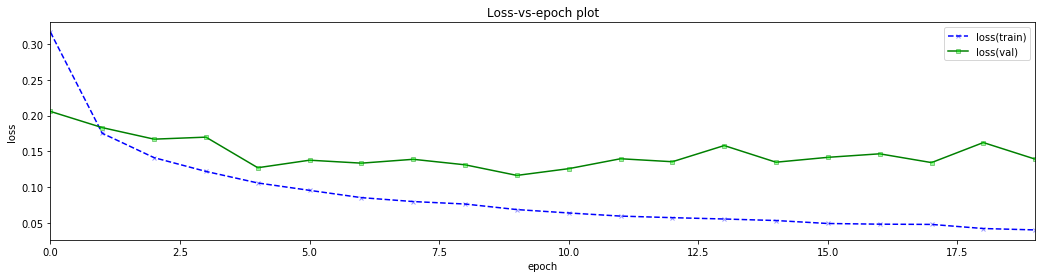

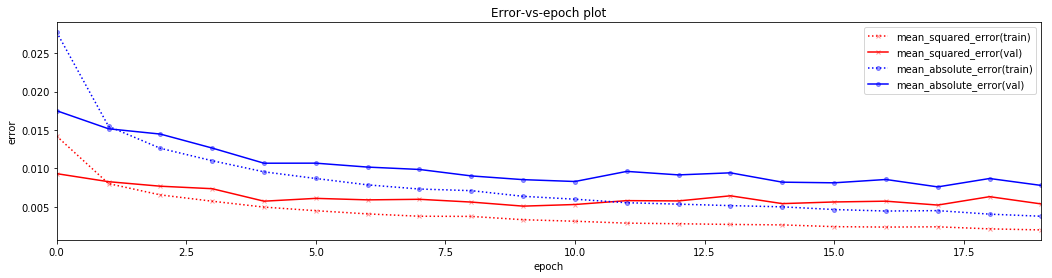

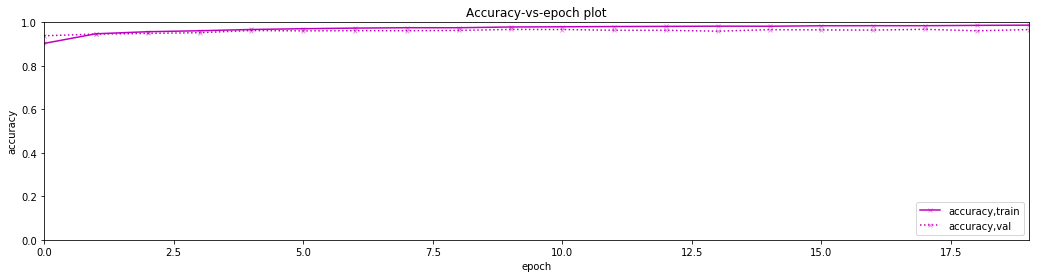

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def MakePlots(history):
    N=3
    FX=60
    FY=4
    A=0.4
    S=4

    # Plot loss
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 1)
    plt.plot(history.history["loss"]    , "b--x", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.plot(history.history["val_loss"], "g-s" , markerfacecolor=(0, 1, 0, A), markersize=S)
    plt.legend(loc="best", labels=("loss(train)","loss(val)"))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.xlim((0, EPOCHS-1))
    plt.title("Loss-vs-epoch plot")
    plt.show()

    # Plot all metrics + loss
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 2)
    plt.plot(history.history["mean_squared_error"],      "r:x", markerfacecolor=(1, 0, 0, A), markersize=S)
    plt.plot(history.history["val_mean_squared_error"],  "r-x", markerfacecolor=(1, 0, 0, A), markersize=S)
    plt.plot(history.history["mean_absolute_error"],     "b:o", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.plot(history.history["val_mean_absolute_error"], "b-o", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.xlabel("epoch")
    plt.ylabel("error")
    plt.xlim((0, EPOCHS-1))
    plt.legend(loc="best", labels=("mean_squared_error(train)",  "mean_squared_error(val)", 
                                   "mean_absolute_error(train)", "mean_absolute_error(val)"))
    plt.title("Error-vs-epoch plot")
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 3)
    plt.plot(history.history["categorical_accuracy"],     "m-x", markerfacecolor=(1, 0, 1, A), markersize=S)
    plt.plot(history.history["val_categorical_accuracy"], "m:x", markerfacecolor=(1, 0, 1, A), markersize=S)
    ax.set_ylim([0,1])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.xlim((0, EPOCHS-1))
    plt.legend(loc="lower right", labels=("accuracy,train","accuracy,val"))
    plt.title("Accuracy-vs-epoch plot")
    plt.show()

MakePlots(history)

In [5]:
model = Sequential()
model.add(Dense(input_dim=(784), units=20, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
# Grp10: 20, 50, 70, 100, 70, 50, 20
AddLayer(model, 50,  dropout_rate=DROPOUT_RATE)
AddLayer(model, 70,  dropout_rate=DROPOUT_RATE)
AddLayer(model, 100, dropout_rate=DROPOUT_RATE)
AddLayer(model, 70,  dropout_rate=DROPOUT_RATE)
AddLayer(model, 50,  dropout_rate=DROPOUT_RATE)
AddLayer(model, 20,  dropout_rate=DROPOUT_RATE)
model.add(Dense(units=10, 
                activation="softmax",
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     

ModelCompile(model)

start = time()
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=EPOCHS, 
                    verbose=VERBOSE)
t = time()-start

PrintScore(model, X_test, y_test_cat, t)
MakePlots(history)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                15700     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                1050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 70)                3570      
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               7100      
___________________________

KeyboardInterrupt: 

In [ ]:
   # NOTE: ups, remembered convert to float but forgot scale 
X_norm = X*np.float32(1) # NOTE: remembered convert to float and scale 

print(f"X.shape={X.shape}")
print(f"  type(X_norm[0][0])={type(X_norm[0][0])}")
print(f"  X_norm.dtype={X_norm.dtype}")
print(f"  np.max(X_norm)={np.max(X_norm)}")
print(f"  np.min(X_norm)={np.min(X_norm)}")

start = time()
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=EPOCHS, 
                    verbose=VERBOSE)
t = time()-start

PrintScore(model, X_test, y_test_cat, t)
MakePlots(history)

In [ ]:
model = Sequential()
model.add(Dense(input_dim=(784), units=20, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
# Grp10: 20, 50, 70, 100, 70, 50, 20
AddLayer(model, 50,  add_normalization=True)
AddLayer(model, 70,  add_normalization=True)
AddLayer(model, 100, add_normalization=True)
AddLayer(model, 70,  add_normalization=True)
AddLayer(model, 50,  add_normalization=True)
AddLayer(model, 20,  add_normalization=True)
model.add(Dense(units=10, 
                activation="softmax",
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     

ModelCompile(model)

start = time()
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=EPOCHS, 
                    verbose=VERBOSE)
t = time()-start

PrintScore(model, X_test, y_test_cat, t)
MakePlots(history)